<a href="https://colab.research.google.com/github/mehmetalivarol/veri-analitigi-egitim/blob/master/lstm_time_series_DZ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
mpl.rcParams['figure.figsize'] = (12, 7)
mpl.rcParams['axes.grid'] = False

In [0]:
df = pd.read_excel('/content/drive/My Drive/Colab Data/DZ.linkterasend.xlsx')
df['Units'] = pd.to_numeric(df['Units'], errors='coerce')
df = df.dropna(subset=['Units'])
df = df.reset_index(drop=True)

print('Number of rows and columns after removing missing values:', df.shape)
print('The time series starts from: ', df.date.min())
print('The time series ends on: ', df.date.max())


Number of rows and columns after removing missing values: (761, 2)
The time series starts from:  2017-07-01 00:00:00
The time series ends on:  2019-07-31 00:00:00


In [0]:
df.head()

,date,Units
0,2017-07-01,67
1,2017-07-02,0
2,2017-07-03,275
3,2017-07-04,183
4,2017-07-05,176


In [0]:
stat, p = stats.normaltest(df.Units)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

Statistics=36.186, p=0.000
Data does not look Gaussian (reject H0)


Kurtosis of normal distribution: -0.6616265159455672
Skewness of normal distribution: 0.1899422110534846


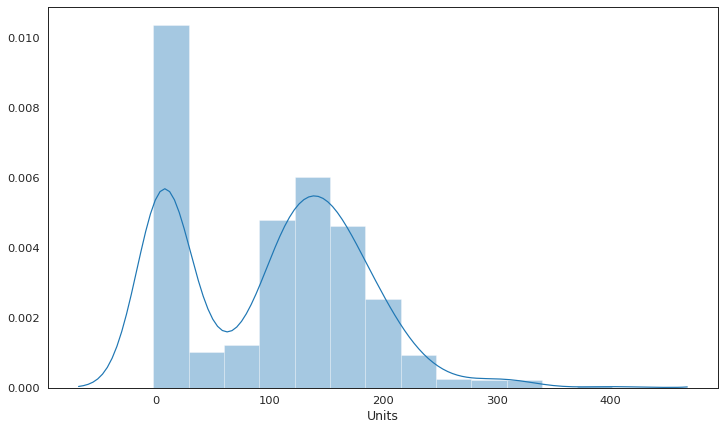

In [0]:
sns.distplot(df.Units);
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(df.Units)))
print( 'Skewness of normal distribution: {}'.format(stats.skew(df.Units)))

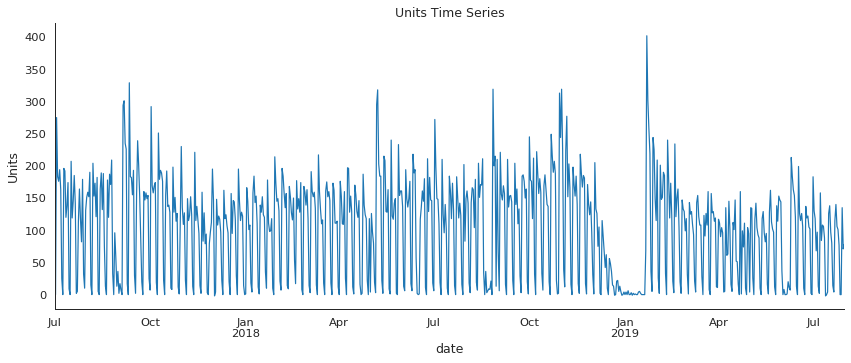

In [0]:
df1=df.loc[:,['date','Units']]
df1.set_index('date',inplace=True)
df1.plot(figsize=(12,5))
plt.ylabel('Units')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('Units Time Series')
sns.despine(top=True)
plt.show();

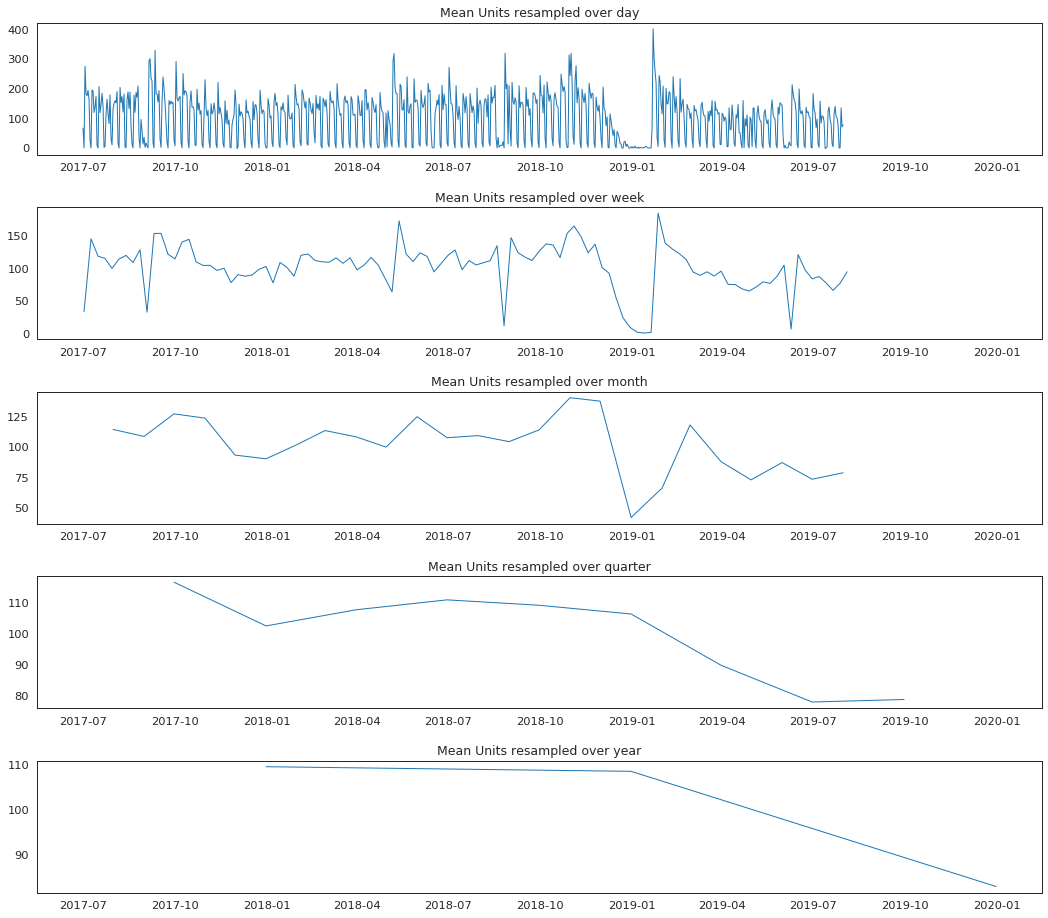

In [0]:
fig = plt.figure(figsize=(18,16))
fig.subplots_adjust(hspace=.4)
ax1 = fig.add_subplot(5,1,1)
ax1.plot(df1['Units'].resample('D').mean(),linewidth=1)
ax1.set_title('Mean Units resampled over day')
ax1.tick_params(axis='both', which='major')

ax2 = fig.add_subplot(5,1,2, sharex=ax1)
ax2.plot(df1['Units'].resample('W').mean(),linewidth=1)
ax2.set_title('Mean Units resampled over week')
ax2.tick_params(axis='both', which='major')

ax3 = fig.add_subplot(5,1,3, sharex=ax1)
ax3.plot(df1['Units'].resample('M').mean(),linewidth=1)
ax3.set_title('Mean Units resampled over month')
ax3.tick_params(axis='both', which='major')

ax4  = fig.add_subplot(5,1,4, sharex=ax1)
ax4.plot(df1['Units'].resample('Q').mean(),linewidth=1)
ax4.set_title('Mean Units resampled over quarter')
ax4.tick_params(axis='both', which='major')

ax5  = fig.add_subplot(5,1,5, sharex=ax1)
ax5.plot(df1['Units'].resample('A').mean(),linewidth=1)
ax5.set_title('Mean Units resampled over year')
ax5.tick_params(axis='both', which='major');

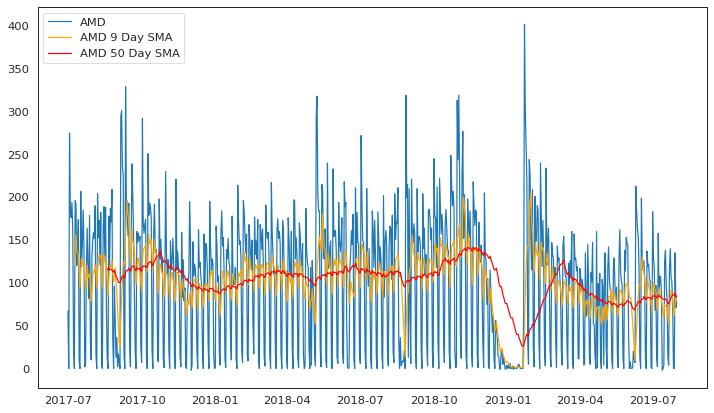

In [0]:
from statsmodels.nonparametric.smoothers_lowess import lowess
plt.rcParams.update({'xtick.bottom' : False, 'axes.titlepad':5})

df['ma9'] = df.Units.rolling(window=9).mean()
rolling_mean = df.Units.rolling(window=9).mean()
rolling_mean2 = df.Units.rolling(window=50).mean()
plt.plot(df.date, df.Units, label='AMD')
plt.plot(df.date, rolling_mean, label='AMD 9 Day SMA', color='orange')
plt.plot(df.date, rolling_mean2, label='AMD 50 Day SMA', color='red')
plt.legend(loc='upper left')
plt.show()



In [0]:
df['loess_5'] = pd.DataFrame(lowess(df.Units, np.arange(len(df.Units)), frac=0.03)[:, 1], index=df.index, columns=['Units'])

In [0]:
df.head(20)

,date,Units,ma9
0,2017-07-01,67,nan
1,2017-07-02,0,nan
2,2017-07-03,275,nan
3,2017-07-04,183,nan
4,2017-07-05,176,nan
5,2017-07-06,194,nan
6,2017-07-07,163,nan
7,2017-07-08,25,nan
8,2017-07-09,0,120.3333
9,2017-07-10,196,134.6667


In [0]:
dataset = df.ma9[8:761].values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 1
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [0]:
from keras import optimizers
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50,return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(50,return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))
Adam=keras.optimizers.Adam(lr=0.001)
model.compile(loss='mean_squared_error', optimizer='Adam')

history = model.fit(X_train, Y_train, epochs=100, batch_size= 16, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience= 10)], verbose=1, shuffle=False)
model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 600 samples, validate on 149 samples
Epoch 1/100





600/600 [==============================] - 4s 7ms/step - loss: 0.2068 - val_loss: 0.0128
Epoch 2/100
600/600 [==============================] - 0s 724us/step - loss: 0.0313 - val_loss: 0.0148
Epoch 3/100
600/600 [==============================] - 0s 721us/step - loss: 0.0234 - val_loss: 0.0176
Epoch 4/100
600/600 [==============================] - 0s 725us/step - loss: 0.0204 - val_loss: 0.0153
Epoch 5/100
600/600 [==============================] - 0s 701us/step - loss: 0.0192 - val_loss: 0.0144
Epoch 6/100
600/600 [==============================] - 0s 732us/step - loss: 0.0165 - val_loss: 0.0131
Epoch 7/100
600/600 [==============================] - 0s 705us/step - loss: 0.0139 - val_loss: 0.0078
Epoch 8/100
6

In [0]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))



Train Mean Absolute Error: 11.37798015226666
Train Root Mean Squared Error: 13.561502658395606
Test Mean Absolute Error: 9.135886135416888
Test Root Mean Squared Error: 10.42931677800855


In [0]:
df['Units'].mean()

101.6688567674113

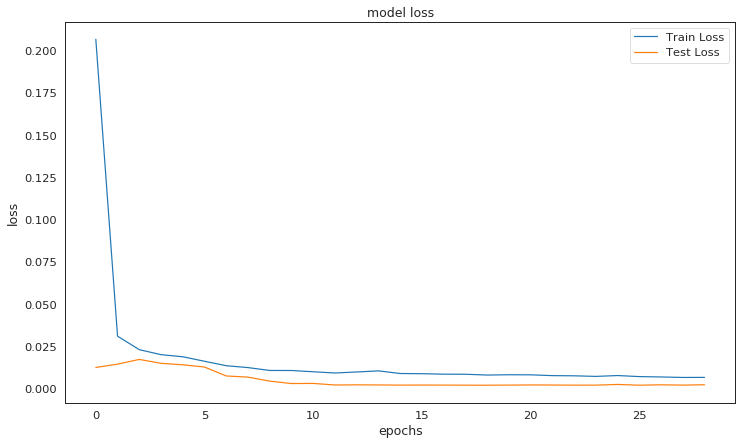

In [0]:
plt.figure(figsize=(12,7))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

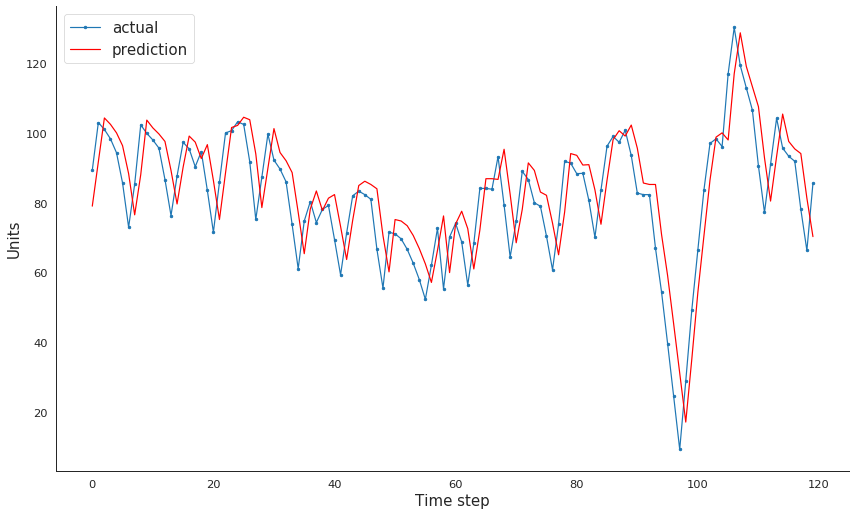

In [0]:
aa=[x for x in range(120)]
plt.figure(figsize=(12,7))
plt.plot(aa, Y_test[0][:120], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:120], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Units', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();